In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MaxAbsScaler, RobustScaler, Normalizer
from sklearn.model_selection import GridSearchCV

from pathlib import Path
import pickle

from surrogates.system import SystemSurrogate
from utils import ax_default

In [47]:
# Load the full SystemSurrogate
save_dir = 'build_2023-07-18T01.48.39'
root_dir = Path('../../surrogates') / save_dir
surr = SystemSurrogate.load_from_file(root_dir / 'sys' / 'sys_final.pkl', root_dir=root_dir)
surr.set_output_dir({'Thruster': None})  # Don't save outputs for testing
qoi_idx = [2]

# Load training set (just thruster i/o)
with open(Path('../../surrogates') / 'training_set.pkl', 'rb') as fd:
    data = pickle.load(fd)
    xtrain = data['x']   # (N, 14)
    ytrain = data['y']   # (N, ydim)
ytrain = ytrain[:, [i-1 for i in qoi_idx]]

# Load test set (global system i/o)
with open(Path('../../surrogates') / 'test_set.pkl', 'rb') as fd:
    data = pickle.load(fd)
    xtest = data['xt']
    ytest = data['yt']
yt_surr = surr(xtest)
yt_surr = yt_surr[:, qoi_idx]                                               # (Nt, Nq)
thruster_idx = [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 13, 14, 15]
xtest = np.concatenate((xtest[:, thruster_idx], ytest[:, 0:1]), axis=-1)    # (Nt, 14)
ytest = ytest[:, qoi_idx]                                                   # (Nt, Nq)

# Compute system surrogate relative error
rel_error = np.sqrt(np.mean((ytest - yt_surr)**2, axis=0)) / np.sqrt(np.mean(ytest**2, axis=0))     # (Nq,)
print(f'System surrogate relative error: {rel_error}')

2023-08-11 11:32:34,175 — [INFO] — surrogates.system.SystemSurrogate    — SystemSurrogate loaded from C:\Users\eckel\Documents\GitHub\HallThrusterPEM\surrogates\build_2023-07-18T01.48.39\sys\sys_final.pkl
System surrogate relative error: [7.12647314]


In [48]:
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((5188, 14), (1071, 14), (5188, 1), (1071, 1))

System surrogate fit R2 values: [0.43854169 0.80840154 0.79202097]. Uniform average: 0.679654732488593


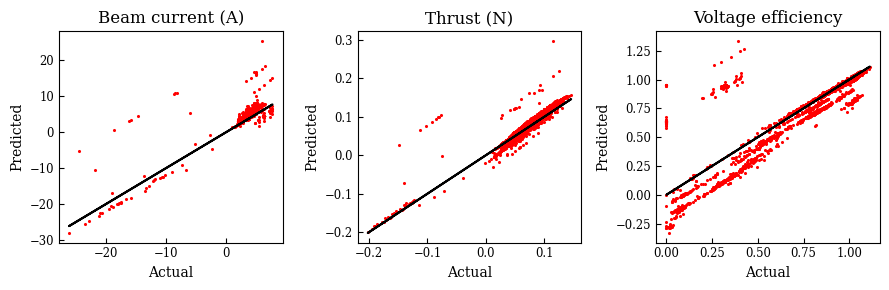

In [6]:
# Test MISC surrogate on training set
model = surr.get_component('Thruster')
ytrain_ridge = model(xtrain)[:, [i-1 for i in qoi_idx]]
r2 = 1 - np.sum((ytrain_ridge - ytrain)**2, axis=0) / np.sum((ytrain_ridge - np.mean(ytrain_ridge, axis=0))**2, axis=0)
print(f'System surrogate fit R2 values: {r2}. Uniform average: {np.mean(r2)}')

fig, ax = plt.subplots(1, len(qoi_idx))
labels = ['Beam current (A)', 'Thrust (N)', 'Voltage efficiency']
for i in range(len(qoi_idx)):
    ax[i].scatter(ytrain[:, i], ytrain_ridge[:, i], c='r', s=1.5)
    ax[i].plot(ytrain[:, i], ytrain[:, i], '-k')
    ax[i].set_title(labels[i])
    ax_default(ax[i], 'Actual', 'Predicted', legend=False)
fig.set_size_inches(9, 3)
fig.tight_layout()
plt.show()

In [49]:
# Filter high pressure and negative thrust cases
idx = np.where(xtrain[:, 0] < -4)[0]
xt = xtrain[idx, :]
yt = ytrain[idx, :]
idx = np.where(yt[:, 0] > 0)[0]
xt = xt[idx, :]
yt = yt[idx, :]

In [50]:
idx = np.where(xtest[:, 0] < -4)[0]
xt_test = xtest[idx, :]
yt_test = ytest[idx, :]
idx = np.where(yt_test[:, 0] > 0)[0]
xt_test = xt_test[idx, :]
yt_test = yt_test[idx, :]

In [52]:
xtrain, ytrain = xt, yt
xtest, ytest = xt_test, yt_test
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((4781, 14), (4781, 1), (882, 14), (882, 1))

Linear fit relative error: [0.18513926], R^2: 0.6312779668669963


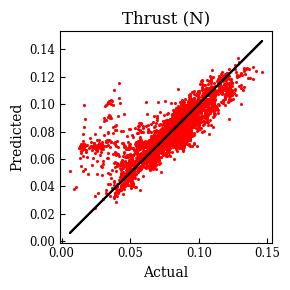

In [56]:
# Test scikit-learn regression
model = Ridge(alpha=0.1)
model.fit(xtrain, ytrain)
r2 = model.score(xtrain, ytrain)
yt_ridge = model.predict(xtest)
rel_error = np.sqrt(np.mean((ytest - yt_ridge)**2, axis=0)) / np.sqrt(np.mean(ytest**2, axis=0))     # (Nq,)
print(f'Linear fit relative error: {rel_error}, R^2: {r2}')

fig, axs = plt.subplots(1, len(qoi_idx))
ytrain_ridge = model.predict(xtrain)
labels = ['Cathode coupling voltage (V)', 'Beam current (A)', 'Thrust (N)', 'Voltage efficiency']
for i in range(len(qoi_idx)):
    ax = axs[i] if len(qoi_idx) > 1 else axs
    ax.scatter(ytrain[:, i], ytrain_ridge[:, i], c='r', s=1.5)
    ax.plot(ytrain[:, i], ytrain[:, i], '-k')
    ax.set_title(labels[qoi_idx[i]])
    ax_default(ax, 'Actual', 'Predicted', legend=False)
fig.set_size_inches(3*len(qoi_idx), 3)
fig.tight_layout()
plt.show()

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END features__degree=2, scaler=StandardScaler();, score=0.738 total time=   0.0s
[CV 2/5] END features__degree=2, scaler=StandardScaler();, score=0.753 total time=   0.0s
[CV 3/5] END features__degree=2, scaler=StandardScaler();, score=0.730 total time=   0.0s
[CV 4/5] END features__degree=2, scaler=StandardScaler();, score=0.716 total time=   0.0s
[CV 5/5] END features__degree=2, scaler=StandardScaler();, score=0.800 total time=   0.0s
[CV 1/5] END features__degree=2, scaler=MaxAbsScaler();, score=0.726 total time=   0.0s
[CV 2/5] END features__degree=2, scaler=MaxAbsScaler();, score=0.756 total time=   0.0s
[CV 3/5] END features__degree=2, scaler=MaxAbsScaler();, score=0.728 total time=   0.0s
[CV 4/5] END features__degree=2, scaler=MaxAbsScaler();, score=0.711 total time=   0.0s
[CV 5/5] END features__degree=2, scaler=MaxAbsScaler();, score=0.799 total time=   0.0s
[CV 1/5] END features__degree=3, scaler=StandardSc

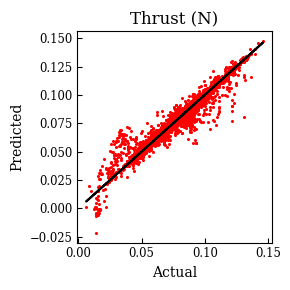

In [57]:
# Test scikit-learn regression
pipe = Pipeline([('scaler', StandardScaler()),
                  ('features', PolynomialFeatures()),
                  ('model', Ridge(alpha=1))])
params = {'features__degree': [2, 3, 4],
          'scaler': [StandardScaler(), MaxAbsScaler()]
          }
model = GridSearchCV(pipe, params, cv=5, verbose=3)
model.fit(xtrain, ytrain)
r2 = model.score(xtrain, ytrain)
yt_ridge = model.predict(xtest)
rel_error = np.sqrt(np.mean((ytest - yt_ridge) ** 2, axis=0)) / np.sqrt(np.mean(ytest ** 2, axis=0))  # (Nq,)
print(f'Linear fit relative error: {rel_error}, R^2: {r2}')

fig, axs = plt.subplots(1, len(qoi_idx))
ytrain_ridge = model.predict(xtrain)
labels = ['Cathode coupling voltage (V)', 'Beam current (A)', 'Thrust (N)', 'Voltage efficiency']
for i in range(len(qoi_idx)):
    ax = axs[i] if len(qoi_idx) > 1 else axs
    ax.scatter(ytrain[:, i], ytrain_ridge[:, i], c='r', s=1.5)
    ax.plot(ytrain[:, i], ytrain[:, i], '-k')
    ax.set_title(labels[qoi_idx[i]])
    ax_default(ax, 'Actual', 'Predicted', legend=False)
fig.set_size_inches(3*len(qoi_idx), 3)
fig.tight_layout()
plt.show()

Fitting 10 folds for each of 15 candidates, totalling 150 fits
[CV 1/10] END model__alpha=0.01, model__kernel__length_scale=0.01;, score=-20.295 total time=   4.0s
[CV 2/10] END model__alpha=0.01, model__kernel__length_scale=0.01;, score=-18.455 total time=   2.8s
[CV 3/10] END model__alpha=0.01, model__kernel__length_scale=0.01;, score=-16.243 total time=   2.0s
[CV 4/10] END model__alpha=0.01, model__kernel__length_scale=0.01;, score=-43.759 total time=   2.0s
[CV 5/10] END model__alpha=0.01, model__kernel__length_scale=0.01;, score=-20.749 total time=   2.0s
[CV 6/10] END model__alpha=0.01, model__kernel__length_scale=0.01;, score=-22.576 total time=   2.2s
[CV 7/10] END model__alpha=0.01, model__kernel__length_scale=0.01;, score=-119.313 total time=   2.4s
[CV 8/10] END model__alpha=0.01, model__kernel__length_scale=0.01;, score=-23.193 total time=   2.3s
[CV 9/10] END model__alpha=0.01, model__kernel__length_scale=0.01;, score=-26.127 total time=   2.5s
[CV 10/10] END model__alpha

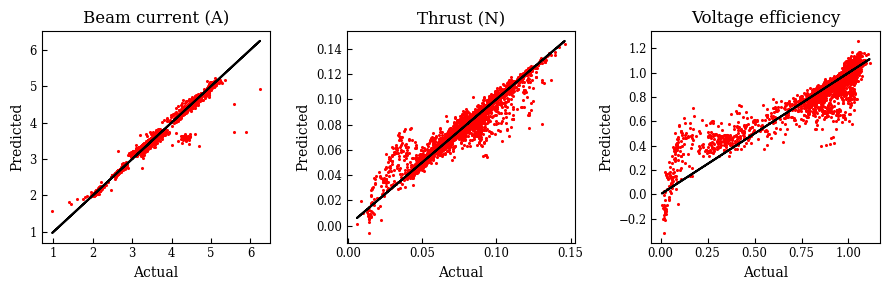

In [38]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF

pipe = Pipeline([('scaler', MaxAbsScaler()),
                  ('model', GaussianProcessRegressor(n_restarts_optimizer=0, kernel=RBF(length_scale_bounds='fixed')))])
params = {'model__alpha': [1e-2, 1e-1, 1],
          'model__kernel__length_scale': [0.01, 0.1, 1, 10, 100]
          }
model = GridSearchCV(pipe, params, cv=10, verbose=3)
model.fit(xtrain, ytrain)
r2 = model.score(xtrain, ytrain)
yt_ridge = model.predict(xtest)
rel_error = np.sqrt(np.mean((ytest - yt_ridge) ** 2, axis=0)) / np.sqrt(np.mean(ytest ** 2, axis=0))  # (Nq,)
print(f'Linear fit relative error: {rel_error}, R^2: {r2}')

fig, ax = plt.subplots(1, len(qoi_idx))
ytrain_ridge = model.predict(xtrain)
labels = ['Beam current (A)', 'Thrust (N)', 'Voltage efficiency']
for i in range(len(qoi_idx)):
    ax[i].scatter(ytrain[:, i], ytrain_ridge[:, i], c='r', s=1.5)
    ax[i].plot(ytrain[:, i], ytrain[:, i], '-k')
    ax[i].set_title(labels[i])
    ax_default(ax[i], 'Actual', 'Predicted', legend=False)
fig.set_size_inches(9, 3)
fig.tight_layout()
plt.show()

Iteration 1, loss = 1.39814550
Iteration 2, loss = 0.67047401
Iteration 3, loss = 0.35406678
Iteration 4, loss = 0.20598491
Iteration 5, loss = 0.13011251
Iteration 6, loss = 0.09011519
Iteration 7, loss = 0.07289769
Iteration 8, loss = 0.06692604
Iteration 9, loss = 0.06426752
Iteration 10, loss = 0.06348484
Iteration 11, loss = 0.06317868
Iteration 12, loss = 0.06299015
Iteration 13, loss = 0.06286234
Iteration 14, loss = 0.06272594
Iteration 15, loss = 0.06255987
Iteration 16, loss = 0.06237418
Iteration 17, loss = 0.06216815
Iteration 18, loss = 0.06194246
Iteration 19, loss = 0.06168687
Iteration 20, loss = 0.06140084
Iteration 21, loss = 0.06108910
Iteration 22, loss = 0.06075469
Iteration 23, loss = 0.06036089
Iteration 24, loss = 0.05995776
Iteration 25, loss = 0.05948323
Iteration 26, loss = 0.05900714
Iteration 27, loss = 0.05851035
Iteration 28, loss = 0.05801116
Iteration 29, loss = 0.05750968
Iteration 30, loss = 0.05699435
Iteration 31, loss = 0.05651721
Iteration 32, los

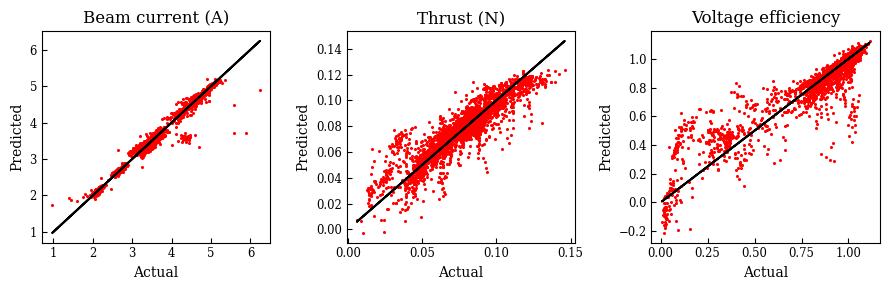

In [39]:
from sklearn.neural_network import MLPRegressor

pipe = Pipeline([('scaler', MaxAbsScaler()),
                  ('model', MLPRegressor(activation='tanh', hidden_layer_sizes=(50, 10), alpha=1e-2, learning_rate_init=0.001, max_iter=4000, verbose=True, tol=1e-12, batch_size=512, n_iter_no_change=50, validation_fraction=0.1))])
# params = {'model__hidden_layer_sizes': [(20, 10), (20, 10, 5), (50, 30, 10), (10, 5)],
#           'model__alpha': [1e-4, 1e-3, 1e-2, 1e-1],
#           'model__learning_rate_init': [1e-3, 1e-2, 1e-1]
#           }
# model = GridSearchCV(pipe, params, cv=10, verbose=3)
model = pipe
model.fit(xtrain, ytrain)
r2 = model.score(xtrain, ytrain)
yt_ridge = model.predict(xtest)
rel_error = np.sqrt(np.mean((ytest - yt_ridge) ** 2, axis=0)) / np.sqrt(np.mean(ytest ** 2, axis=0))  # (Nq,)
print(f'MLP fit relative error: {rel_error}, R^2: {r2}')

fig, ax = plt.subplots(1, len(qoi_idx))
ytrain_ridge = model.predict(xtrain)
labels = ['Beam current (A)', 'Thrust (N)', 'Voltage efficiency']
for i in range(len(qoi_idx)):
    ax[i].scatter(ytrain[:, i], ytrain_ridge[:, i], c='r', s=1.5)
    ax[i].plot(ytrain[:, i], ytrain[:, i], '-k')
    ax[i].set_title(labels[i])
    ax_default(ax[i], 'Actual', 'Predicted', legend=False)
fig.set_size_inches(9, 3)
fig.tight_layout()
plt.show()

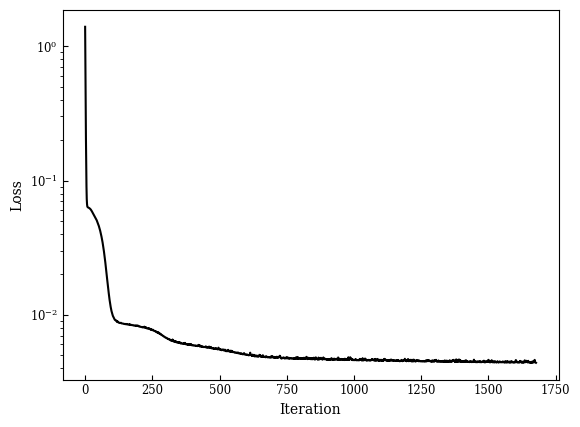

In [40]:
l = model['model'].loss_curve_
fig, ax = plt.subplots()
ax.plot(l, '-k')
ax.set_yscale('log')
ax_default(ax, 'Iteration', 'Loss', legend=False)
plt.show()

In [96]:
# Find what is causing negative thrust and NaN cases
import os
save_dir = 'build_2023-07-18T01.48.39'
root_dir = Path('../surrogates') / save_dir / 'components' / 'Thruster'
x = np.zeros((0, 14))
y = np.zeros((0, 26))
for f in os.listdir(root_dir):
    if f.endswith('.pkl'):
        with open(root_dir / f, 'rb') as fd:
            data = pickle.load(fd)
            x = np.concatenate((x, data['x']), axis=0)
            y = np.concatenate((y, data['y']), axis=0)
x.shape, y.shape

((6476, 14), (6476, 26))

In [108]:
nan_idx = np.where(np.any(np.isnan(y), axis=-1))[0]
neg_idx = np.where(y[:, 1] < 0)[0]
nan_idx.shape, neg_idx.shape

((77,), (121,))

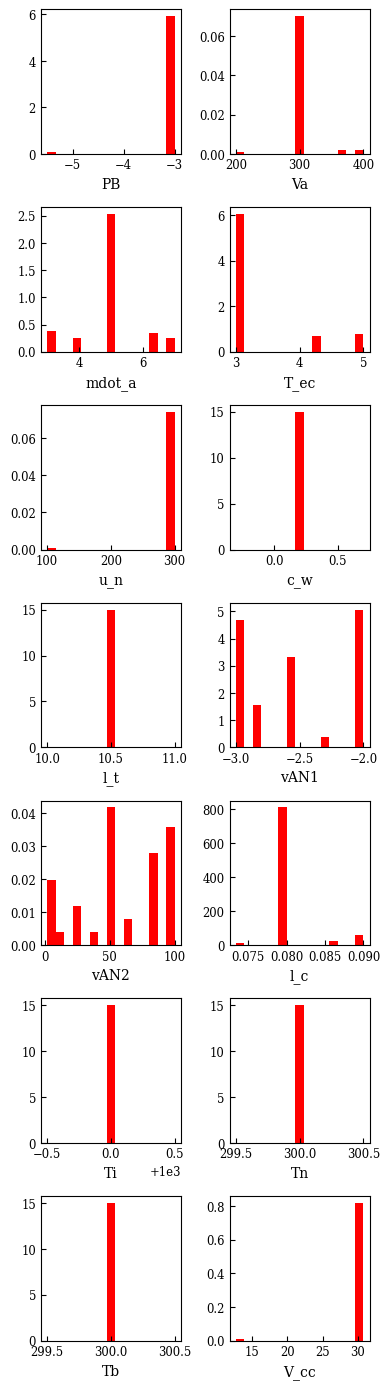

In [135]:
fig, axs = plt.subplots(7, 2)
curr_idx = 0
thruster_idx = [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 13, 14, 15]
labels = [str(var) for i, var in enumerate(surr.exo_vars) if i in thruster_idx] + ['V_cc']
for i in range(7):
    for j in range(2):
        ax = axs[i, j]
        ax.hist(x[nan_idx, curr_idx], color='red', linewidth=1.2, density=True, bins=15)
        ax_default(ax, labels[curr_idx], '', legend=False)
        curr_idx += 1
fig.set_size_inches(4, 14)
fig.tight_layout()
plt.show()

In [132]:
np.where(x[nan_idx, 0] < -4)

(array([46], dtype=int64),)